# LeakDB

In [83]:
#Load data from all scenarios
import pickle

# Load dictionary from pickle file
with open("scenario_data.pkl", "rb") as f:
    G = pickle.load(f)

print(type(G)) 

<class 'dict'>


In [84]:
# Check structure
print(G['Scenario'].keys()) 

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])


In [85]:
# Inspect the structure of the available data
for scenario, scenario_data in G.items():
    print(f"Scenario: {scenario}")  # Prints the scenario number
    
    for subfolder, subfolder_data in scenario_data.items():
        if (int(subfolder) < 4):
            print(f"  Subfolder: {subfolder}")  # Prints the subfolder name

            for file, df in subfolder_data.items():
                    print(f"    File: {file}")  # Prints the CSV filename
        else:
             break

Scenario: Scenario
  Subfolder: 1
    File: Labels.csv
    File: Scenario-1_info.csv
    File: Demands
    File: Flows
    File: Leaks
    File: Pressures
  Subfolder: 2
    File: Labels.csv
    File: Scenario-2_info.csv
    File: Demands
    File: Flows
    File: Leaks
    File: Pressures
  Subfolder: 3
    File: Labels.csv
    File: Scenario-3_info.csv
    File: Demands
    File: Flows
    File: Leaks
    File: Pressures


In [86]:
import pandas as pd

#Processes demands, pressures, flows, and leaks for a given scenario in `G`.
def process_df_node_data(scenario_dict):

    demands_dict = scenario_dict.get("Demands", {})
    pressures_dict = scenario_dict.get("Pressures", {})
    flows_dict = scenario_dict.get("Flows", {})
    # gather data associated with nodes

    nodes_data = []
    for file_name in sorted(demands_dict.keys()):
        if file_name in pressures_dict:
            d_df = demands_dict[file_name]
            p_df = pressures_dict[file_name]

            # Merge on common node identifier (assuming "NodeID" column)
            merged_df = d_df.merge(p_df, on="Timestamp", suffixes=("_Demand", "_Pressure"))                
            merged_df.rename(columns={"Value_Demand": "Demand", "Value_Pressure": "Pressure", "Description": "Leak_Demand"}, inplace=True)
            merged_df['node_id'] = file_name.replace('.csv', '')
            nodes_data.append(merged_df)

    # Combine all time-step data for demands and pressures
    nodes_data = pd.concat(nodes_data, ignore_index=True) if nodes_data else None

    # Gather data associated with pipes (links)
    links_data = []
    for file_name in sorted(flows_dict):
        f_df = flows_dict[file_name]
        f_df['link_id'] = file_name.replace('.csv', '')
        links_data.append(f_df)

    # Combine all time-step data for flows
    links_data = pd.concat(links_data, ignore_index=True) if links_data else None

    # Return structured data
    return nodes_data, links_data

In [87]:
# Save processed data from all scenarios in a single dictionary
processed_scenarios = {}

for scenario in G["Scenario"]:
    nodes_data, links_data = process_df_node_data(G["Scenario"][scenario])
    processed_scenarios[scenario] = {"nodes": nodes_data, "links": links_data}

In [88]:
# Select one specific scenario for the EDA
nodes_scenario1 = processed_scenarios["1"]['nodes']
links_scenario1 = processed_scenarios["1"]['links']

In [89]:
links_scenario1

,Timestamp,Value,link_id
0,2017-01-01 00:00:00,3405.6,Link_1
1,2017-01-01 00:30:00,2970.0,Link_1
2,2017-01-01 01:00:00,2656.8,Link_1
3,2017-01-01 01:30:00,2401.2,Link_1
4,2017-01-01 02:00:00,2199.6,Link_1
...,...,...,...
595675,2017-12-31 21:30:00,1047.6,Link_9
595676,2017-12-31 22:00:00,990.0,Link_9
595677,2017-12-31 22:30:00,932.4,Link_9
595678,2017-12-31 23:00:00,838.8,Link_9


In [90]:
# Create df with unique identifiers for each sensor measurement, regarding demands
demands_scenario1 = []
demands_scenario1 = nodes_scenario1.drop(columns = "Pressure")
demands_scenario1["sensor_id"] = (demands_scenario1["node_id"] + "_demand")
demands_scenario1 = demands_scenario1.drop(columns = "node_id").rename(columns = {"Demand": "measurement"})
demands_scenario1["sensor_type"] = "demand"
demands_scenario1

,Timestamp,measurement,sensor_id,sensor_type
0,2017-01-01 00:00:00,-3405.6,Node_1_demand,demand
1,2017-01-01 00:30:00,-2970.0,Node_1_demand,demand
2,2017-01-01 01:00:00,-2656.8,Node_1_demand,demand
3,2017-01-01 01:30:00,-2401.2,Node_1_demand,demand
4,2017-01-01 02:00:00,-2199.6,Node_1_demand,demand
...,...,...,...,...
560635,2017-12-31 21:30:00,140.4,Node_9_demand,demand
560636,2017-12-31 22:00:00,126.0,Node_9_demand,demand
560637,2017-12-31 22:30:00,122.4,Node_9_demand,demand
560638,2017-12-31 23:00:00,118.8,Node_9_demand,demand


In [91]:
# Create df with unique identifiers for each sensor measurement, regarding pressures
pressures_scenario1 = []
pressures_scenario1 = nodes_scenario1.drop(columns = "Demand")
pressures_scenario1["sensor_id"] = (pressures_scenario1["node_id"] + "_pressure")
pressures_scenario1 = pressures_scenario1.drop(columns = "node_id").rename(columns = {"Pressure": "measurement"})
pressures_scenario1["sensor_type"] = "pressure"
pressures_scenario1

,Timestamp,measurement,sensor_id,sensor_type
0,2017-01-01 00:00:00,0.000,Node_1_pressure,pressure
1,2017-01-01 00:30:00,0.000,Node_1_pressure,pressure
2,2017-01-01 01:00:00,0.000,Node_1_pressure,pressure
3,2017-01-01 01:30:00,0.000,Node_1_pressure,pressure
4,2017-01-01 02:00:00,0.000,Node_1_pressure,pressure
...,...,...,...,...
560635,2017-12-31 21:30:00,62.525,Node_9_pressure,pressure
560636,2017-12-31 22:00:00,63.275,Node_9_pressure,pressure
560637,2017-12-31 22:30:00,64.155,Node_9_pressure,pressure
560638,2017-12-31 23:00:00,64.956,Node_9_pressure,pressure


In [92]:
# Create df with unique identifiers for each sensor measurement, regarding flows
flows_scenario1 = links_scenario1.copy()
flows_scenario1["sensor_id"] = (links_scenario1["link_id"] + "_flow")
flows_scenario1 = flows_scenario1.drop(columns = "link_id").rename(columns = {"Value": "measurement"})
flows_scenario1["sensor_type"] = "flow"
flows_scenario1

,Timestamp,measurement,sensor_id,sensor_type
0,2017-01-01 00:00:00,3405.6,Link_1_flow,flow
1,2017-01-01 00:30:00,2970.0,Link_1_flow,flow
2,2017-01-01 01:00:00,2656.8,Link_1_flow,flow
3,2017-01-01 01:30:00,2401.2,Link_1_flow,flow
4,2017-01-01 02:00:00,2199.6,Link_1_flow,flow
...,...,...,...,...
595675,2017-12-31 21:30:00,1047.6,Link_9_flow,flow
595676,2017-12-31 22:00:00,990.0,Link_9_flow,flow
595677,2017-12-31 22:30:00,932.4,Link_9_flow,flow
595678,2017-12-31 23:00:00,838.8,Link_9_flow,flow


In [93]:
# Create df with unique identifiers for each sensor measurement, regarding flows
flows_scenario1 = links_scenario1.copy()
flows_scenario1["sensor_id"] = (links_scenario1["link_id"] + "_flow")
flows_scenario1 = flows_scenario1.drop(columns = "link_id").rename(columns = {"Value": "measurement"})
flows_scenario1["sensor_type"] = "flow"
flows_scenario1

,Timestamp,measurement,sensor_id,sensor_type
0,2017-01-01 00:00:00,3405.6,Link_1_flow,flow
1,2017-01-01 00:30:00,2970.0,Link_1_flow,flow
2,2017-01-01 01:00:00,2656.8,Link_1_flow,flow
3,2017-01-01 01:30:00,2401.2,Link_1_flow,flow
4,2017-01-01 02:00:00,2199.6,Link_1_flow,flow
...,...,...,...,...
595675,2017-12-31 21:30:00,1047.6,Link_9_flow,flow
595676,2017-12-31 22:00:00,990.0,Link_9_flow,flow
595677,2017-12-31 22:30:00,932.4,Link_9_flow,flow
595678,2017-12-31 23:00:00,838.8,Link_9_flow,flow


In [94]:
# Now that we have a unique ID for each demand, pressure and flow, we put them all together in our final measurements dataframe
all_scenario1 = pd.concat([demands_scenario1, pressures_scenario1, flows_scenario1], ignore_index=True)
all_scenario1['unique_id'] = all_scenario1['sensor_id'] + '_' + all_scenario1["Timestamp"].astype(str)
all_scenario1

,Timestamp,measurement,sensor_id,sensor_type,unique_id
0,2017-01-01 00:00:00,-3405.6,Node_1_demand,demand,Node_1_demand_2017-01-01 00:00:00
1,2017-01-01 00:30:00,-2970.0,Node_1_demand,demand,Node_1_demand_2017-01-01 00:30:00
2,2017-01-01 01:00:00,-2656.8,Node_1_demand,demand,Node_1_demand_2017-01-01 01:00:00
3,2017-01-01 01:30:00,-2401.2,Node_1_demand,demand,Node_1_demand_2017-01-01 01:30:00
4,2017-01-01 02:00:00,-2199.6,Node_1_demand,demand,Node_1_demand_2017-01-01 02:00:00
...,...,...,...,...,...
1716955,2017-12-31 21:30:00,1047.6,Link_9_flow,flow,Link_9_flow_2017-12-31 21:30:00
1716956,2017-12-31 22:00:00,990.0,Link_9_flow,flow,Link_9_flow_2017-12-31 22:00:00
1716957,2017-12-31 22:30:00,932.4,Link_9_flow,flow,Link_9_flow_2017-12-31 22:30:00
1716958,2017-12-31 23:00:00,838.8,Link_9_flow,flow,Link_9_flow_2017-12-31 23:00:00


In [95]:
all_scenario1

,Timestamp,measurement,sensor_id,sensor_type,unique_id
0,2017-01-01 00:00:00,-3405.6,Node_1_demand,demand,Node_1_demand_2017-01-01 00:00:00
1,2017-01-01 00:30:00,-2970.0,Node_1_demand,demand,Node_1_demand_2017-01-01 00:30:00
2,2017-01-01 01:00:00,-2656.8,Node_1_demand,demand,Node_1_demand_2017-01-01 01:00:00
3,2017-01-01 01:30:00,-2401.2,Node_1_demand,demand,Node_1_demand_2017-01-01 01:30:00
4,2017-01-01 02:00:00,-2199.6,Node_1_demand,demand,Node_1_demand_2017-01-01 02:00:00
...,...,...,...,...,...
1716955,2017-12-31 21:30:00,1047.6,Link_9_flow,flow,Link_9_flow_2017-12-31 21:30:00
1716956,2017-12-31 22:00:00,990.0,Link_9_flow,flow,Link_9_flow_2017-12-31 22:00:00
1716957,2017-12-31 22:30:00,932.4,Link_9_flow,flow,Link_9_flow_2017-12-31 22:30:00
1716958,2017-12-31 23:00:00,838.8,Link_9_flow,flow,Link_9_flow_2017-12-31 23:00:00


In [111]:
all_scenario1.to_csv("measurements_1_leakDB.csv")

In [96]:
# We can select specific types of measurements
all_scenario1[all_scenario1['sensor_type'] == 'demand']

,Timestamp,measurement,sensor_id,sensor_type,unique_id
0,2017-01-01 00:00:00,-3405.6,Node_1_demand,demand,Node_1_demand_2017-01-01 00:00:00
1,2017-01-01 00:30:00,-2970.0,Node_1_demand,demand,Node_1_demand_2017-01-01 00:30:00
2,2017-01-01 01:00:00,-2656.8,Node_1_demand,demand,Node_1_demand_2017-01-01 01:00:00
3,2017-01-01 01:30:00,-2401.2,Node_1_demand,demand,Node_1_demand_2017-01-01 01:30:00
4,2017-01-01 02:00:00,-2199.6,Node_1_demand,demand,Node_1_demand_2017-01-01 02:00:00
...,...,...,...,...,...
560635,2017-12-31 21:30:00,140.4,Node_9_demand,demand,Node_9_demand_2017-12-31 21:30:00
560636,2017-12-31 22:00:00,126.0,Node_9_demand,demand,Node_9_demand_2017-12-31 22:00:00
560637,2017-12-31 22:30:00,122.4,Node_9_demand,demand,Node_9_demand_2017-12-31 22:30:00
560638,2017-12-31 23:00:00,118.8,Node_9_demand,demand,Node_9_demand_2017-12-31 23:00:00


## Basic demand, pressure and flow visualizations

C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\1767002983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demands_scenario1['Timestamp'] = pd.to_datetime(demands_scenario1['Timestamp'])
C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\1767002983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demands_scenario1['hour'] = demands_scenario1['Timestamp'].dt.hour


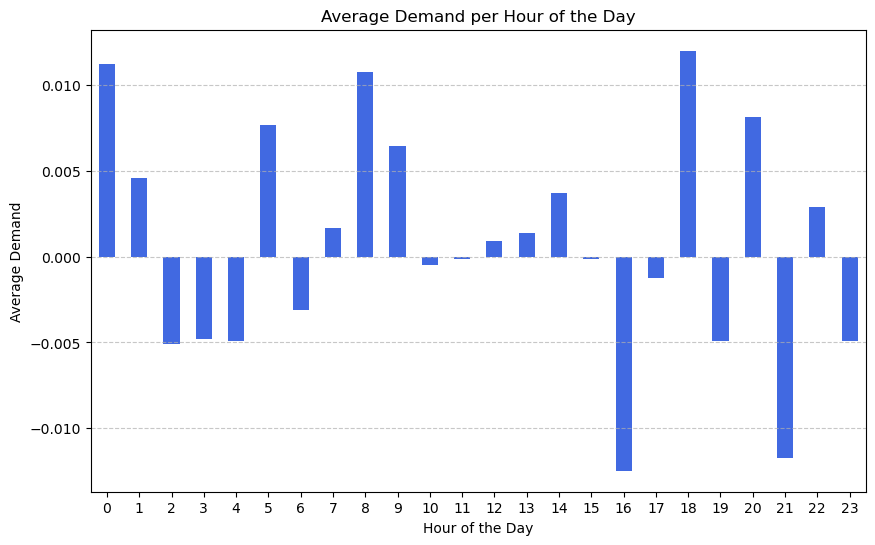

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

demands_scenario1 = all_scenario1[all_scenario1['sensor_type'] == 'demand']
demands_scenario1['Timestamp'] = pd.to_datetime(demands_scenario1['Timestamp'])
demands_scenario1['hour'] = demands_scenario1['Timestamp'].dt.hour
avg_demand_by_hour = demands_scenario1.groupby('hour')['measurement'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
avg_demand_by_hour.plot(kind='bar', color='royalblue')
plt.title('Average Demand per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Demand')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\2699835283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pressures_scenario1['Timestamp'] = pd.to_datetime(pressures_scenario1['Timestamp'])
C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\2699835283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pressures_scenario1['hour'] = pressures_scenario1['Timestamp'].dt.hour


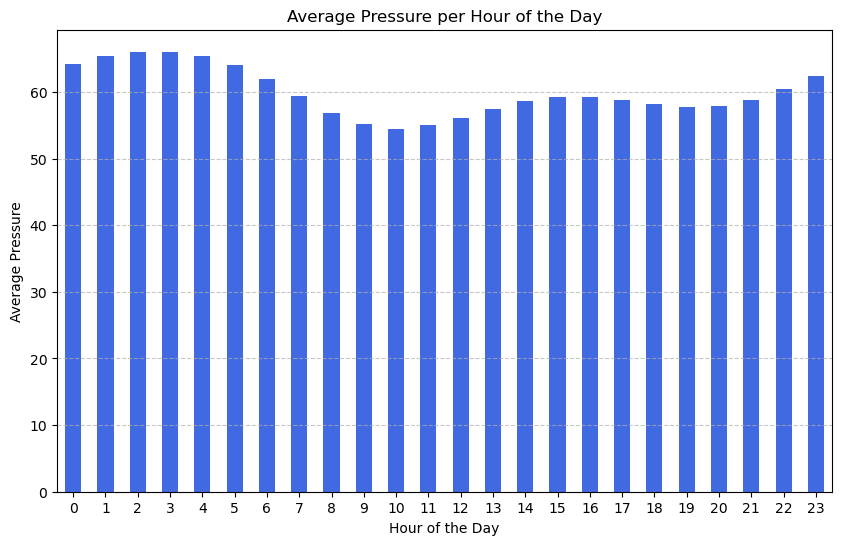

In [104]:
pressures_scenario1 = all_scenario1[all_scenario1['sensor_type'] == 'pressure']
pressures_scenario1['Timestamp'] = pd.to_datetime(pressures_scenario1['Timestamp'])
pressures_scenario1['hour'] = pressures_scenario1['Timestamp'].dt.hour
avg_pressure_by_hour = pressures_scenario1.groupby('hour')['measurement'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
avg_pressure_by_hour.plot(kind='bar', color='royalblue')
plt.title('Average Pressure per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Pressure')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\3748454748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_scenario1['Timestamp'] = pd.to_datetime(flows_scenario1['Timestamp'])
C:\Users\Pepe\AppData\Local\Temp\ipykernel_37884\3748454748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_scenario1['hour'] = flows_scenario1['Timestamp'].dt.hour


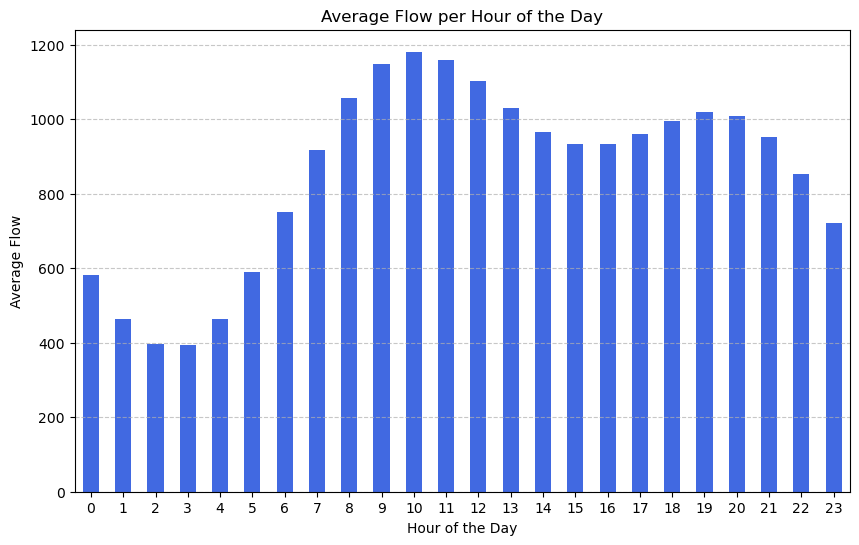

In [105]:
flows_scenario1 = all_scenario1[all_scenario1['sensor_type'] == 'flow']
flows_scenario1['Timestamp'] = pd.to_datetime(flows_scenario1['Timestamp'])
flows_scenario1['hour'] = flows_scenario1['Timestamp'].dt.hour
avg_flow_by_hour = flows_scenario1.groupby('hour')['measurement'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
avg_flow_by_hour.plot(kind='bar', color='royalblue')
plt.title('Average Flow per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Flow')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Basic Scenario Description

In [106]:
# Number of nodes (can be found on sensor and pressure measurements)
all_scenario1[all_scenario1['sensor_type'] == 'demand']["sensor_id"].nunique()

32

In [107]:
# Number of pipes (found in flows dataset)
all_scenario1[all_scenario1['sensor_type'] == 'flow']["sensor_id"].nunique()

34